In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis_sol
import matplotlib.pyplot as plt
importlib.reload(kgs)
#pack_vis.plot_polygons([kgs.center_tree] + kgs.convex_breakdown)

local
local


<module 'kaggle_support' from '/mnt/d/packing/code/analysis/../core/kaggle_support.py'>

In [2]:
# Compare final scores across multiple seeds
SEEDS_TO_DO = [114,115,116,117,118,119]
#SEEDS_TO_DO = [110,111]

import numpy as np
import glob
import matplotlib.pyplot as plt
import re

# Collect final scores for each seed
seed_scores = {seed: {} for seed in SEEDS_TO_DO}

for N_trees in np.arange(20,81,2):
    files = glob.glob(kgs.temp_dir + f'/*runs/done/ga_N{N_trees}_*.pickle')
    
    for f in files:
        # Extract seed from filename
        seed = None
        for s in SEEDS_TO_DO:
            if f'seed{s}' in f or f'_{s}' in f or f's{s}' in f:
                seed = s
                break
        
        if seed is None:
            # Try to parse seed from filename more generically
            seed_match = re.search(r'seed(\d+)|s(\d+)|_(\d+)(?!.*N\d)', f)
            if seed_match:
                parsed_seed = int(seed_match.group(1) or seed_match.group(2) or seed_match.group(3))
                if parsed_seed in SEEDS_TO_DO:
                    seed = parsed_seed
        
        if seed is not None:
            # Load data and get final score
            dat = kgs.dill_load(f)
            final_score = dat.ga.champions[0].phenotype.h[0,0].get()**2/N_trees  # Last generation's best cost
            seed_scores[seed][N_trees] = final_score

# Collect all N_trees values across all seeds
all_N_trees = set()
for seed in SEEDS_TO_DO:
    all_N_trees.update(seed_scores[seed].keys())
all_N_trees = sorted(all_N_trees)


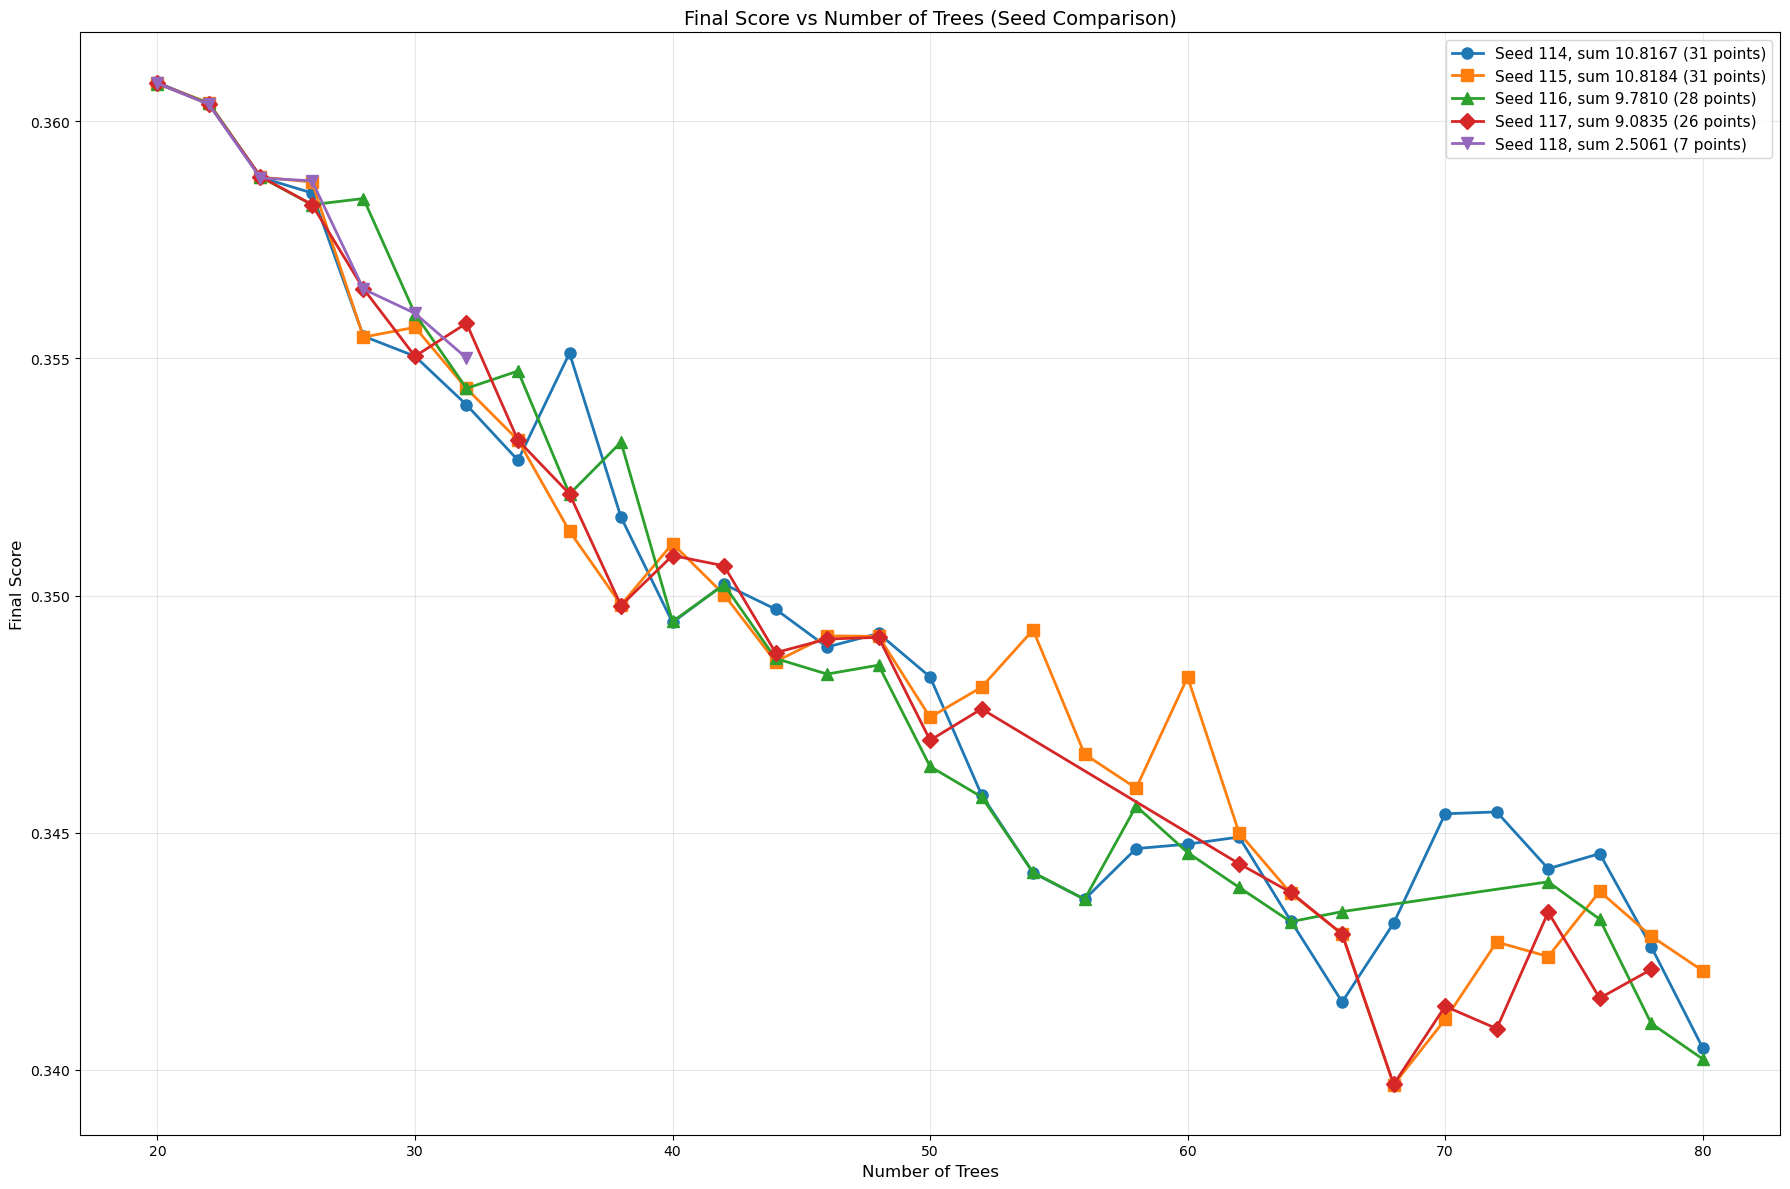

Plotted 31 total N_trees values: [np.int64(20), np.int64(22), np.int64(24), np.int64(26), np.int64(28), np.int64(30), np.int64(32), np.int64(34), np.int64(36), np.int64(38), np.int64(40), np.int64(42), np.int64(44), np.int64(46), np.int64(48), np.int64(50), np.int64(52), np.int64(54), np.int64(56), np.int64(58), np.int64(60), np.int64(62), np.int64(64), np.int64(66), np.int64(68), np.int64(70), np.int64(72), np.int64(74), np.int64(76), np.int64(78), np.int64(80)]
  Seed 114: 31 data points
  Seed 115: 31 data points
  Seed 116: 28 data points
  Seed 117: 26 data points
  Seed 118: 7 data points
  Seed 119: 0 data points


In [3]:
# Create plot
plt.figure(figsize=(18, 12))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*', 'h']

for i, seed in enumerate(SEEDS_TO_DO):
    # Get values for this seed (None for missing data)
    n_trees_list = []
    values = []
    for n in all_N_trees:
        if n in seed_scores[seed]:
            n_trees_list.append(n)
            values.append(seed_scores[seed][n])
    
    if values:  # Only plot if there's at least one value
        marker = markers[i % len(markers)]
        plt.plot(n_trees_list, values, marker=marker, linestyle=None, 
                label=f'Seed {seed}, sum {np.sum(values):.4f} ({len(values)} points)', 
                linewidth=2, markersize=8)

plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Final Score', fontsize=12)
plt.title('Final Score vs Number of Trees (Seed Comparison)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Plotted {len(all_N_trees)} total N_trees values: {all_N_trees}")
for seed in SEEDS_TO_DO:
    print(f"  Seed {seed}: {len(seed_scores[seed])} data points")

In [4]:
for seeds_to_include in [[114,115], [114,115,116,117], [114,115,116,117,118,119]]:
    res = []
    for N_trees in np.arange(20,201,2):
        best = np.inf
        for seed in seeds_to_include:
            if N_trees in seed_scores[seed] and seed_scores[seed][N_trees] < best:
                best = seed_scores[seed][N_trees]
        res.append(best)
    print(np.sum(res))

inf
inf
inf


In [5]:
import shutil
import zipfile
import os
try:
    shutil.rmtree(kgs.temp_dir + '/rerun/')
except: pass
os.makedirs(kgs.temp_dir + '/rerun/')
for N_trees in np.arange(82,201,2):
    best = np.inf
    best_seed = None
    for seed in SEEDS_TO_DO:
        if N_trees in seed_scores[seed] and seed_scores[seed][N_trees] < best:
            best = seed_scores[seed][N_trees]
            best_seed = seed
    src = kgs.temp_dir + f'/controller_runs/ga_N{N_trees}_seed{best_seed}.pickle'
    dst = kgs.temp_dir + f'/rerun/ga_N{N_trees}_seed{best_seed}.pickle'
    shutil.copyfile(src, dst)
# Create a zip file from the rerun folder
zip_path = kgs.temp_dir + '/rerun.zip'
with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(kgs.temp_dir + '/rerun/'):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, kgs.temp_dir)
            zipf.write(file_path, arcname)

print(f"Created zip file: {zip_path}")

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/d//packing/temp//controller_runs/ga_N82_seedNone.pickle'

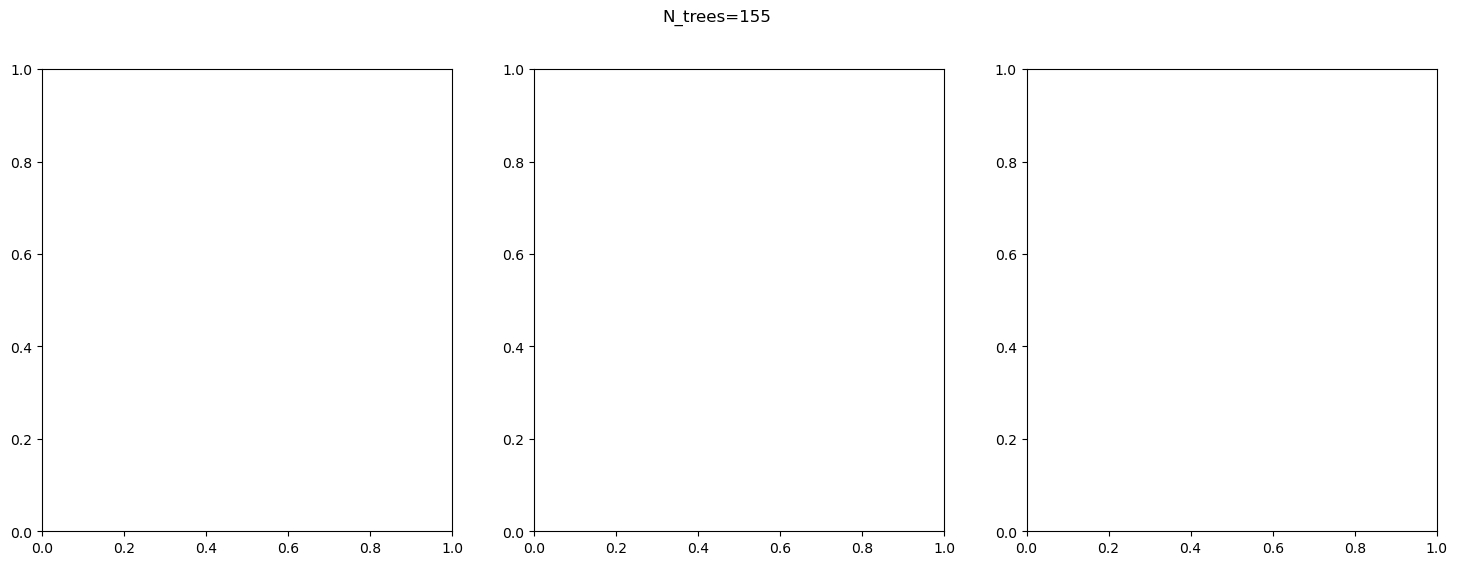

In [ ]:
for N_trees in [155]:
    seeds = [120,122,124]
    res = []
    for s in seeds:
        f = kgs.temp_dir + f'/controller_runs/done/ga_N{N_trees}_seed{s}_done.pickle'
        try:
            dat = kgs.dill_load(f)
            res.append(dat.ga.champions[0])
        except Exception as e:
            res.append(None)
    _,ax = plt.subplots(1,3, figsize=(18,6))
    for i,r in enumerate(res):
        if not r is None:
            plt.sca(ax[i])
            pack_vis_sol.pack_vis_sol(r.phenotype, ax=ax[i])
            plt.title(f'Seed {seeds[i]}, score {r.phenotype.h[0,0].get()**2/N_trees:.8f}')
    plt.suptitle(f'N_trees={N_trees}')
    plt.pause(0.001)

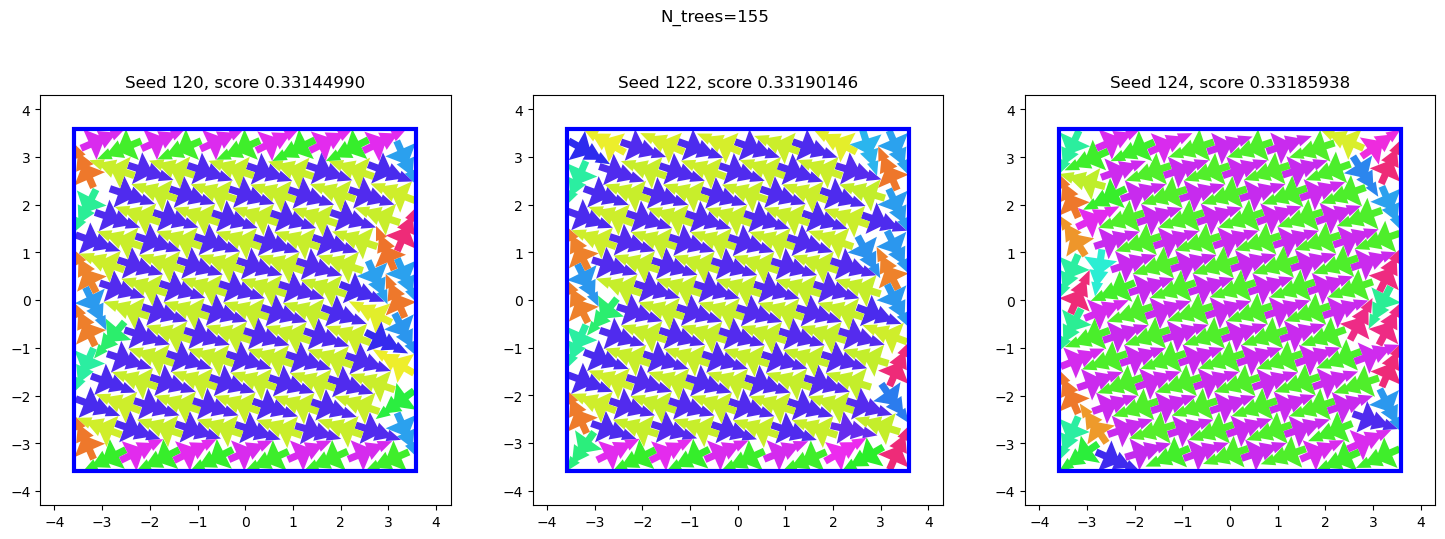

In [ ]:
for N_trees in [155]:
    seeds = [120,122,124]
    res = []
    for s in seeds:
        f = kgs.temp_dir + f'/controller_runs/repro/ga_N{N_trees}_seed{s}_done.pickle'
        try:
            dat = kgs.dill_load(f)
            res.append(dat.ga.champions[0])
        except Exception as e:
            res.append(None)
    _,ax = plt.subplots(1,3, figsize=(18,6))
    for i,r in enumerate(res):
        if not r is None:
            plt.sca(ax[i])
            pack_vis_sol.pack_vis_sol(r.phenotype, ax=ax[i])
            plt.title(f'Seed {seeds[i]}, score {r.phenotype.h[0,0].get()**2/N_trees:.8f}')
    plt.suptitle(f'N_trees={N_trees}')
    plt.pause(0.001)

In [ ]:
2

2